# User input parameters

In [2]:
#filepath_calib="C:/Users/tomfa/Desktop/DSP_spectrum_calibration-master/DSP_spectrum_calibration-master/"
filepath_calib="" # using github clone

#Command Path
filepath_stardata="star_data_raw"

#
TFnum='04'
#Exact File Name
filename="Capture_054.fit"

#Put files in directory "starname" in directory filepath_stardata or change the following file path to open

file_to_open=filepath_stardata+"/TF"+TFnum+"/"+filename 


In [3]:
whos


Variable            Type    Data/Info
-------------------------------------
TFnum               str     04
file_to_open        str     star_data_raw/TF04/Capture_054.fit
filename            str     Capture_054.fit
filepath_calib      str     
filepath_stardata   str     star_data_raw
ih0                 int     3404


In [4]:
### import packages
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
from astropy.io import fits
from scipy import signal


### load argon calibration quartic coefficient matrices



k0=np.load(filepath_calib+"k0.npy")
k1=np.load(filepath_calib+"k1.npy")
k2=np.load(filepath_calib+"k2.npy")
k3=np.load(filepath_calib+"k3.npy")
k4=np.load(filepath_calib+"k4.npy")


In [5]:
TFdict=[{'TF':'01','name':'gam Cas','HD':5394,'mag':2.39},
       {'TF':'02','name':'BK Cam','HD':20336,'mag':4.85},
       {'TF':'03','name':'6 Cep','HD':203467,'mag':5.18},
       {'TF':'04','name':'HD 112028','HD':112028,'mag':5.35},
       {'TF':'05','name':'HD 208682','HD':208682,'mag':5.86},
       {'TF':'06','name':'HD 9612','HD':9612,'mag':6.57},
       {'TF':'07','name':'FF Cam','HD':60062,'mag':7.90},
       {'TF':'08','name':'HD 20566','HD':20566,'mag':7.94},
       {'TF':'09','name':'HD 203024','HD':203024,'mag':8.86},
       {'TF':'10','name':'EM* MWC 680','mag':9.41},
       {'TF':'11','name':'EM* StHA 198','mag':10.54},
       {'TF':'12','name':'EM* AS 518','mag':10.61},
       {'TF':'13','name':'EM* GGR 192','mag':10.67}]

TFdf = pd.DataFrame(TFdict)

#Star Name
starname=TFdf.set_index('TF').loc[TFnum]['name']


#TFdf.loc['04']
#TFdf

# Input Command Path to Raw Star Data:

In [6]:
### load raw data

hdulist = fits.open(file_to_open)  
print(repr(hdulist[0].header))
scidata=hdulist[0].data

SIMPLE  =                    T                                                  
BITPIX  =                   16                                                  
NAXIS   =                    2                                                  
NAXIS1  =                 2749                                                  
NAXIS2  =                  700                                                  
BZERO   =           32768.000000                                                
BSCALE  =             1.000000                                                  
DATAMIN =             0.000000                                                  
DATAMAX =           65535.000000                                                
INSTRUME=           'ATIK-460ex: fw rev 3.34'                                   
EXPTIME =           120.000                                                     
DATE-OBS=           '2019-11-13T03:25:48'                                       
XPIXSZ  =           4.540   

## Make sure raw spectrum looks good:

In [7]:
dt=hdulist[0].header['DATE-OBS']
year=dt[0:4]
month=dt[5:7]
day=dt[8:10]
date=year+month+day
print(date)
hr=dt[11:13]
minute=dt[14:16]
second=dt[17:19]
clockreading=hr+minute+second
print(clockreading)

outfilename="star_spectral_data/TF"+TFnum+"_"+date+"_"+clockreading
print(outfilename)

20191113
032548
star_spectral_data/TF04_20191113_032548


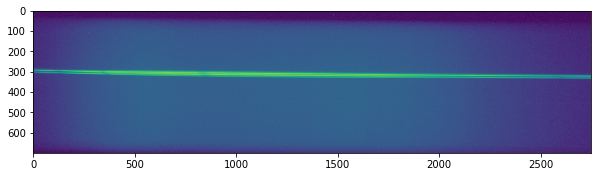

In [8]:
#Show raw Spectrum
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(scidata**.1)

#plt.savefig("C:/Users/tomfa/Desktop/Spectrum")


# Generate and Normalize initial Graph

Bad Pixels = 1173
i2500 = 322.315
y0 = 199
323 322
indc = [295.315  295.3258 295.3366 ... 324.9718 324.9826 324.9934]


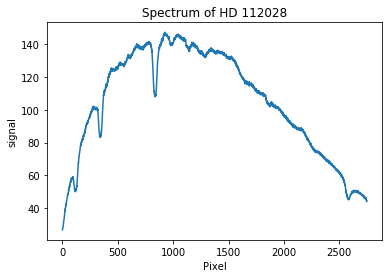

In [9]:
###Correct for exposure time
img=scidata/hdulist[0].header['EXPTIME']  #extract data per unit time
y0=hdulist[0].header['YORGSUBF']   #extract starting y line index from header

###Remove Bad Pixels###



import scipy.signal
img_sm = scipy.signal.medfilt(img, [1,3])
bad = (np.abs(img - img_sm) / 100) > .05
img_cr = img.copy()
img_cr[bad] = img_sm[bad]
ymin=0
ymax=800
ind2=np.argmax(img_cr[ymin:ymax,:],0)+ymin
print("Bad Pixels =", sum(sum(bad)))

###Find indc "line" of Spectrum###
pix=np.arange(0,hdulist[0].header['NAXIS1'],1)
lines=np.arange(0,hdulist[0].header['NAXIS2'],1)

m=.0108 

i2500=np.mean(ind2[2400:2600])
print("i2500 =", i2500)
print("y0 =",y0)
b=i2500-m*2500
indc=m*pix+b
#plt.plot(indc)
#plt.plot(ind2)

###Weighted Average of Nearby Lines###
y=lines
indca, ya = np.meshgrid(indc, lines,indexing='xy')
#print(indca.shape)
sigma=5
w=1/(np.sqrt(2*np.pi)*sigma)*np.e**(-(ya-indca)**2/(2*sigma**2))

###Converting Pixel to Wavelength###
#palpha=np.argmin(s2[2000:2500])+2000
#print(s2[palpha-1],s2[palpha],s2[palpha+1])
#plt.plot(s2[(palpha-30):(palpha+30)])
#m=0.005123
#b=55.616
#palphastar=2557
#pstar=pix+(m*pix+b)*(palphastar-palpha)/(m*palpha+b)

#pc=1375
#ka=5427.504919
#kb=1.011329125
#kc=-4.14239E-05
#kd=-6.61252E-09
#ke=4.787326E-12
#wl=ka+kb*(pstar-pc)+kc*(pstar-pc)**2+kd*(pstar-pc)**3+ke*(pstar-pc)**4

#plt.plot(wl,s2);
#plt.xlabel('wavelength (Angstroms)');
#plt.ylabel('signal');
#plt.title('Spectrum of Phecda')

###Plot Spectrum###
sd= np.sum(w*img_cr,0)

plt.plot(sd)
plt.xlabel('Pixel');
plt.ylabel('signal');
plt.title("Spectrum of "+starname)
print(np.max(ind2[2400:2600]),np.min(ind2[2400:2600]))

print("indc =",indc)

(2749,)


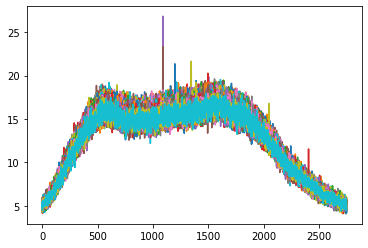

In [10]:
### find average signal in a dark part of slit
### compute background average and subtract off of spectrum
if i2500>400:
    ybgs=200
else:
    ybgs=550

plt.plot(img_cr[ybgs-50:ybgs+50,:].T);  #Make sure this range is good
bg=np.mean(img_cr[ybgs-50:ybgs+50,:],0)
print(bg.shape)


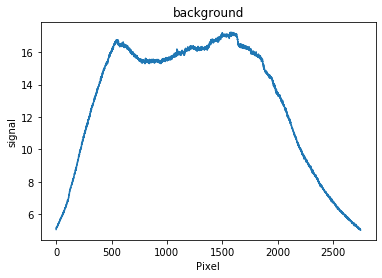

In [11]:
b=ybgs-m*2500
indc=m*pix+b

#print(indca.shape)
indca, ya = np.meshgrid(indc, lines,indexing='xy')

sigma=40
w=1/(np.sqrt(2*np.pi)*sigma)*np.e**(-(ya-indca)**2/(2*sigma**2))

###Plot Spectrum###
bg2= np.sum(w*img_cr,0)

#plt.plot(bg2)
plt.xlabel('Pixel');
plt.ylabel('signal');
plt.title("background")
plt.plot(bg2)

sdbgs=sd-bg2

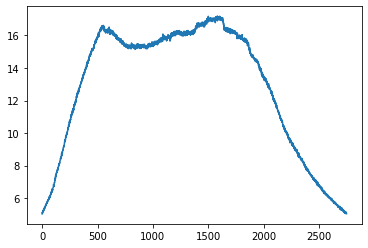

In [12]:
plt.plot(bg)

##This plots hot pixel spots (?)#

550.0

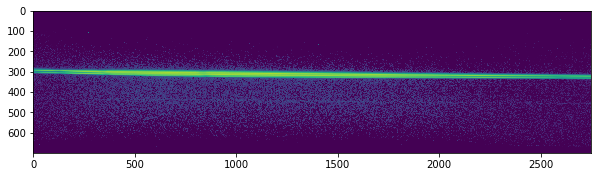

In [13]:
#Show raw Spectrum
imgbgs=img-1.0*bg
#plt.plot(imgbgs)
imgbgs[imgbgs<0]=0

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(np.log((imgbgs+.5)**0.1))

#plt.savefig("C:/Users/tomfa/Desktop/Spectrum")
indc[2500]

Text(0.5, 1.0, 'Spectrum of HD 112028')

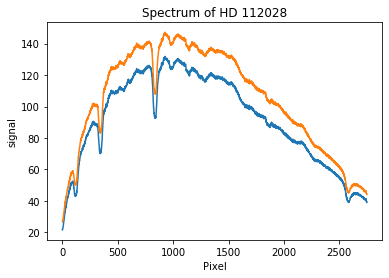

In [14]:
plt.plot(sdbgs)
plt.plot(sd)
plt.xlabel('Pixel');
plt.ylabel('signal');
plt.title("Spectrum of "+starname)

#Plot of Spectrum corrected for 'hot pixels'

# Start Analysis of H-Alpha line

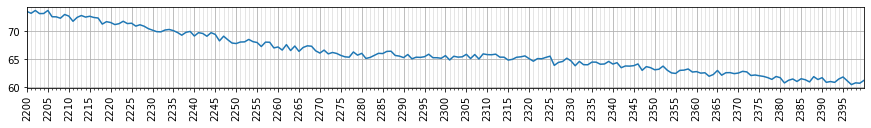

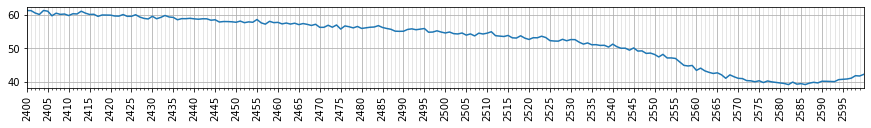

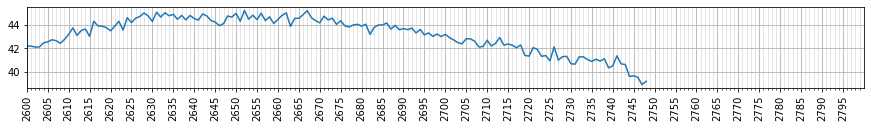

In [83]:


fig, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(15, 1.5))
#fig.suptitle('Horizontally stacked subplots')
xw=200
xa=np.arange(xw+1)
x01=2200

major_ticks = np.arange(0, xw, 5)
minor_ticks = np.arange(0, xw, 1)

length=sdbgs[x01:x01+1+xw].shape[0]
ax1.plot(xa[:length]+x01,sdbgs[x01:x01+1+xw])
ax1.set_xlim(x01,x01+xw)
ax1.set_xticks(major_ticks+x01)
ax1.set_xticks(minor_ticks+x01, minor=True)
ax1.grid(which='both')
ax1.grid(which='minor', alpha=0.4)
ax1.grid(which='major', alpha=1)
ax1.tick_params(axis='x',labelrotation=90)

fig2, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(15, 1.5))
x01=x01+xw
length=sdbgs[x01:x01+1+xw].shape[0]
ax1.plot(xa[:length]+x01,sdbgs[x01:x01+1+xw])
ax1.set_xlim(x01,x01+xw)
ax1.set_xticks(major_ticks+x01)
ax1.set_xticks(minor_ticks+x01, minor=True)
ax1.grid(which='both')
ax1.grid(which='minor', alpha=0.4)
ax1.grid(which='major', alpha=1)
ax1.tick_params(axis='x',labelrotation=90)

fig3, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(15, 1.5))
x01=x01+xw
length=sdbgs[x01:x01+1+xw].shape[0]
ax1.plot(xa[:length]+x01,sdbgs[x01:x01+1+xw])
ax1.set_xlim(x01,x01+xw)
ax1.set_xticks(major_ticks+x01)
ax1.set_xticks(minor_ticks+x01, minor=True)
ax1.grid(which='both')
ax1.grid(which='minor', alpha=0.4)
ax1.grid(which='major', alpha=1)
ax1.tick_params(axis='x',labelrotation=90)

In [167]:
alphaPixel=2557

In [168]:
# find index in used for this camera line (i2500woffset) in k matrix
i2500woffset=i2500+y0
print(i2500woffset)
print(y0)
lineindex=int(np.round(i2500woffset/10))
print(lineindex)

521.315
199
52


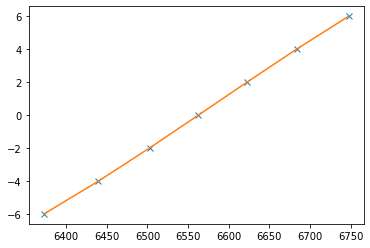

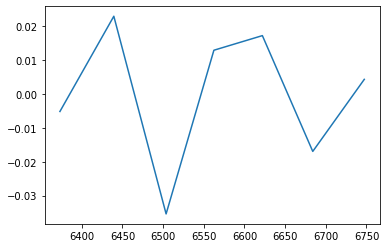

inferred xs =  0.0073402708912908565


In [169]:
### To use this, you need to extract values of:
### li2500: the line of spectrum,
### pixfeature: the pixel of the feature
### and wlfeature: the wavelength of the feature 
### From data
### index 0 changes depending on the y range that we used in capture
li2500=lineindex-26  #260 is index 0, they are spaced by 10 ypixels
#60 is index 0 if we use only the size of the slit I think. Use 6 as subtracted #
#wlfeature=5183.6  pixpk=1109 #Mg from NIST database
wlfeature=6563
#this is wl of Halpha


pixpk=alphaPixel
#pixel where min or max is found in feature


### find xs so that pixfeature and wlfeature match calibration

#first fit (cubicly) xs vs wl at this i2500 and xs
wl=np.polyval((k4[li2500],k3[li2500],k2[li2500],k1[li2500],k0[li2500]),pixpk)
xs=np.arange(-6,7,2)
lfit=np.polyfit(wl,xs,3)

#plot of fit and data
plt.plot(wl,xs,'x');
plt.plot(wl,np.polyval(lfit,wl))
plt.show()

#residuals
plt.plot(wl,xs-np.polyval(lfit,wl));
plt.show()
#extract value of xs corresponding to actual wavelength that index found represents
xse=np.polyval(lfit,wlfeature)
print("inferred xs = ",xse)

[ 4.46825261e-12 -3.30720242e-08  4.56342377e-05  1.02798710e+00
  3.99757836e+03]


2557

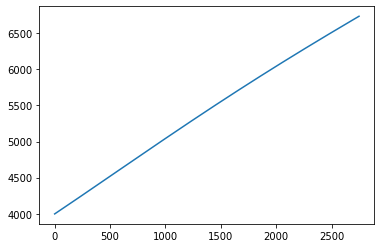

In [170]:
# linear interpolation

from scipy.interpolate import interp1d

f=interp1d(xs,(k4[li2500,:],k3[li2500,:],k2[li2500,:],k1[li2500,:],k0[li2500,:]),fill_value="extrapolate")

km=f(xse)
print(km)
#linearly interpolated coefficients of quartic wl vs pixel fit

#wle should hold the calibrated wavelengths inferred from the interpolated coefficients 
#that match the value of xs inferred from matching pixpk and wlfeature 
pix=np.arange(0,2749)
wle=np.polyval(f(xse),pix)

plt.plot(pix,wle);

#plt.plot(wle,pix);

f2=interp1d(wle,pix)
int(np.round(f2(6563)))

In [171]:
%matplotlib qt

In [172]:
%matplotlib inline

323 322


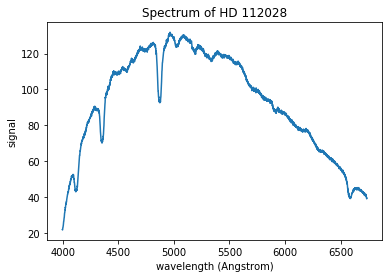

In [173]:
plt.plot(wle,sdbgs)
plt.xlabel('wavelength (Angstrom)');
plt.ylabel('signal');
plt.title("Spectrum of "+starname)
print(np.max(ind2[2400:2600]),np.min(ind2[2400:2600]))

#plt.savefig("C:/Users/tomfa/Desktop/oof")

In [174]:
np.save(filepath_calib+"CSspec",sdbgs)
np.save(filepath_calib+"CSwl",wle)
#This is where the calibrated spectrum is saved.
#I'm not sure what should be changed about this to make the calibrated spectra
#easier to find and read?

### now wavelength is calibrated

###smooth k matrices first?

transfuncM=np.load(filepath_calib+"transfuncM.npy")


# linear interpolation
wlMILES=3500+0.9*np.arange(4367)

from scipy.interpolate import interp1d

#extend data with zeros above and below
wlmin=wle[0];
wlmax=wle[-1];
wlE=np.insert(wle,0,wlmin);
wlE=np.insert(wlE,0,0);
wlE=np.append(wlE,wlmax);
wlE=np.append(wlE,1000000);

y = np.insert(sdbgs,0,0);
y = np.insert(y,0,0);
y = np.append(y,0);
y = np.append(y,0);

f = interp1d(wlE, y)
spM=f(wlMILES)

Text(0.5, 1.0, 'Spectrum of HD 112028')

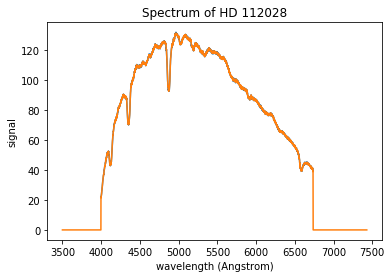

In [175]:
#Plot Normalized Spectrum
plt.plot(wle,sdbgs);
plt.plot(wlMILES,spM);
plt.xlabel('wavelength (Angstrom)');

plt.ylabel('signal');
plt.title("Spectrum of "+starname)

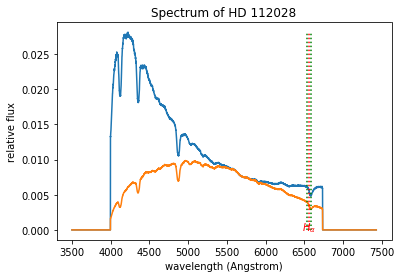

In [176]:
###This is final spectrum
siM=spM/transfuncM
maxy=max(siM)
plt.plot(wlMILES,siM)
plt.plot(wlMILES,spM/max(transfuncM))
plt.xlabel('wavelength (Angstrom)');
plt.ylabel('relative flux');
plt.title("Spectrum of "+starname)
halpha =  6563
plt.plot((halpha, halpha), (-0.00, maxy), ":r")
plt.plot((6535.7,6535.7), (-0.00, maxy), ":g")
plt.plot((wlMILES[3433],wlMILES[3433]), (-0.00, maxy), ":g")
plt.text(halpha, 0, r"$H_\alpha$", color="red", horizontalalignment="center");



In [177]:
siM.shape

(4367,)

In [178]:
wl

array([6373.07555734, 6439.35737614, 6503.63314159, 6562.39442943,
       6622.01822907, 6683.96520751, 6747.3135163 ])

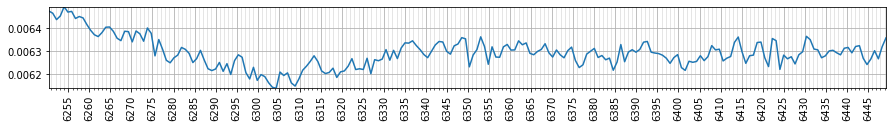

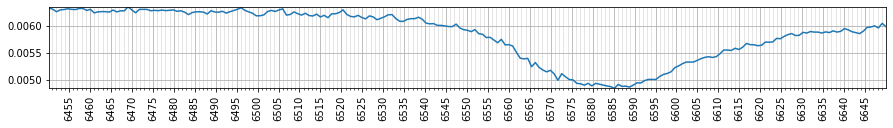

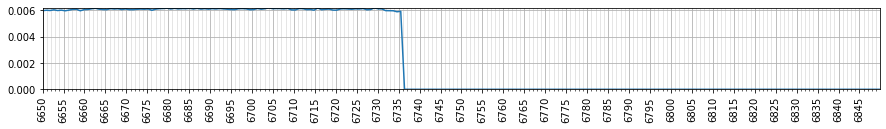

In [199]:


fig, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(15, 1.5))

xmin=6250
xmax=6450

major_ticks = np.arange(xmin,xmax, 5)
minor_ticks = np.arange(xmin,xmax, 1)
mask = (wlMILES >= xmin) & (wlMILES <= xmax)

ax1.plot(wlMILES[mask],siM[mask])

ax1.set_xticks(major_ticks)
ax1.set_xticks(minor_ticks, minor=True)
ax1.grid(which='both')
ax1.grid(which='minor', alpha=0.4)
ax1.grid(which='major', alpha=1)
ax1.tick_params(axis='x',labelrotation=90)
ax1.autoscale(axis='both',tight=True)


fig, ax2 = plt.subplots(nrows=1, ncols=1,figsize=(15, 1.5))

xmin=6450
xmax=6650

major_ticks = np.arange(xmin,xmax, 5)
minor_ticks = np.arange(xmin,xmax, 1)
mask = (wlMILES >= xmin) & (wlMILES <= xmax)

ax2.plot(wlMILES[mask],siM[mask])

ax2.set_xticks(major_ticks)
ax2.set_xticks(minor_ticks, minor=True)
ax2.grid(which='both')
ax2.grid(which='minor', alpha=0.4)
ax2.grid(which='major', alpha=1)
ax2.tick_params(axis='x',labelrotation=90)
ax2.autoscale(axis='both',tight=True)


fig, ax3 = plt.subplots(nrows=1, ncols=1,figsize=(15, 1.5))

xmin=6650
xmax=6850

major_ticks = np.arange(xmin,xmax, 5)
minor_ticks = np.arange(xmin,xmax, 1)
mask = (wlMILES >= xmin) & (wlMILES <= xmax)

ax3.plot(wlMILES[mask],siM[mask])

ax3.set_xticks(major_ticks)
ax3.set_xticks(minor_ticks, minor=True)
ax3.grid(which='both')
ax3.grid(which='minor', alpha=0.4)
ax3.grid(which='major', alpha=1)
ax3.tick_params(axis='x',labelrotation=90)
ax3.autoscale(axis='both',tight=True)


In [200]:
alphacenter=6584

f2=interp1d(wle,pix)
alphaPixel=int(np.round(f2(alphacenter))) 

print(alphaPixel)

2580


inferred xs =  -0.6951349237751856


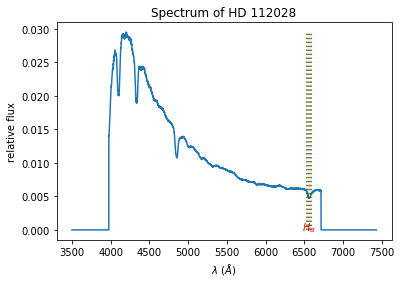

In [202]:

# find index in used for this camera line (i2500woffset) in k matrix
i2500woffset=i2500+y0
#print(i2500woffset)
#print(y0)
lineindex=int(np.round(i2500woffset/10))
#print(lineindex)

### To use this, you need to extract values of:
### li2500: the line of spectrum,
### pixfeature: the pixel of the feature
### and wlfeature: the wavelength of the feature 
### From data
### index 0 changes depending on the y range that we used in capture
li2500=lineindex-26  #260 is index 0, they are spaced by 10 ypixels
#60 is index 0 if we use only the size of the slit I think. Use 6 as subtracted #
#wlfeature=5183.6  pixpk=1109 #Mg from NIST database
wlfeature=6563
#this is wl of Halpha


pixpk=alphaPixel
#pixel where min or max is found in feature


### find xs so that pixfeature and wlfeature match calibration

#first fit (cubicly) xs vs wl at this i2500 and xs
wl=np.polyval((k4[li2500],k3[li2500],k2[li2500],k1[li2500],k0[li2500]),pixpk)
xs=np.arange(-6,7,2)
lfit=np.polyfit(wl,xs,3)

#plot of fit and data
#plt.plot(wl,xs,'x');
#plt.plot(wl,np.polyval(lfit,wl))
#plt.show()

#residuals
#plt.plot(wl,xs-np.polyval(lfit,wl));
#plt.show()
#extract value of xs corresponding to actual wavelength that index found represents
xse=np.polyval(lfit,wlfeature)
print("inferred xs = ",xse)

# linear interpolation

from scipy.interpolate import interp1d

f=interp1d(xs,(k4[li2500,:],k3[li2500,:],k2[li2500,:],k1[li2500,:],k0[li2500,:]),fill_value="extrapolate")

km=f(xse)
#print(km)
#linearly interpolated coefficients of quartic wl vs pixel fit

#wle should hold the calibrated wavelengths inferred from the interpolated coefficients 
#that match the value of xs inferred from matching pixpk and wlfeature 
pix=np.arange(0,2749)
wle=np.polyval(f(xse),pix)

#plt.plot(pix,wle);

#plt.plot(wle,pix);

#f2=interp1d(wle,pix)
#int(np.round(f2(6563)))

#plt.plot(wle,sdbgs)
#plt.xlabel('wavelength (Angstrom)');
#plt.ylabel('signal');
#plt.title("Spectrum of "+starname)
#print(np.max(ind2[2400:2600]),np.min(ind2[2400:2600]))

#This is where the calibrated spectrum is saved.
#I'm not sure what should be changed about this to make the calibrated spectra
#easier to find and read?

### now wavelength is calibrated

###smooth k matrices first?

transfuncM=np.load(filepath_calib+"transfuncM.npy")


# linear interpolation
wlMILES=3500+0.9*np.arange(4367)

from scipy.interpolate import interp1d

#extend data with zeros above and below
wlmin=wle[0];
wlmax=wle[-1];
wlE=np.insert(wle,0,wlmin);
wlE=np.insert(wlE,0,0);
wlE=np.append(wlE,wlmax);
wlE=np.append(wlE,1000000);

y = np.insert(sdbgs,0,0);
y = np.insert(y,0,0);
y = np.append(y,0);
y = np.append(y,0);

f = interp1d(wlE, y)
spM=f(wlMILES)

#Plot Normalized Spectrum
#plt.plot(wle,sdbgs);
#plt.plot(wlMILES,spM);
#plt.xlabel('wavelength (Angstrom)');

#plt.ylabel('signal');
#plt.title("Spectrum of "+starname)

###This is final spectrum
siM=spM/transfuncM
maxy=max(siM)
plt.plot(wlMILES,siM)
#plt.plot(wlMILES,spM/max(transfuncM))
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('relative flux');
plt.title("Spectrum of "+starname)
halpha =  6563
plt.plot((halpha, halpha), (-0.00, maxy), ":r")
plt.plot((6535.7,6535.7), (-0.00, maxy), ":g")
plt.plot((wlMILES[3433],wlMILES[3433]), (-0.00, maxy), ":g")
plt.text(halpha, 0, r"$H_\alpha$", color="red", horizontalalignment="center");


In [203]:
3398

3398

In [204]:
wle.shape

(2749,)

In [205]:
### finding index for each Hydrogen line 
###(trying indices manually until they are the nearest WL below the Hydrogen line)
print(wlMILES[3404],wlMILES[1513],wlMILES[934],wlMILES[669])

mi=(3404,1513,934,669)

print(mi)
wlMILES[mi[0]]


6563.6 4861.7 4340.6 4102.1
(3404, 1513, 934, 669)


6563.6

In [206]:
mi[1]

1513

# Plot H-alpha

6563.6
0.8349625264775237


0.8213972341706438

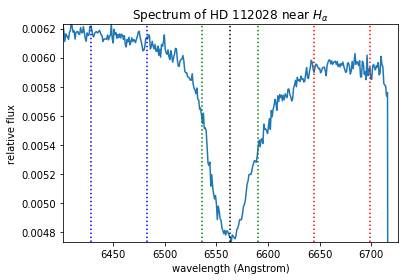

In [207]:
### ih is central index, v mean continuum below, r means continuum above 
### b,t are lower and upper limits of each band
ih=mi[0]
ihb=ih-30
iht=ih+30
ihvb=ih-150
ihvt=ih-90
ihrb=ih+90
ihrt=ih+150


s=np.mean(siM[ihb:iht])
sv=np.mean(siM[ihvb:ihvt])
sr=np.mean(siM[ihrb:ihrt])

normsigh=2*s/(sv+sr)
print(wlMILES[ih])
print(normsigh)

ybottom=min(siM[ihvb:ihrt])
ytop=max(siM[ihvb:ihrt])

plt.plot(wlMILES,siM)
plt.xlabel('wavelength (Angstrom)');
plt.ylabel('relative flux');
plt.title("Spectrum of "+starname+r" near $H_\alpha$")

plt.plot((wlMILES[ih], wlMILES[ih]), (ybottom,ytop), ":k")

plt.plot((wlMILES[ihvt],wlMILES[ihvt]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihvb],wlMILES[ihvb]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihrt],wlMILES[ihrt]), (ybottom,ytop), ":r")
plt.plot((wlMILES[ihrb],wlMILES[ihrb]), (ybottom,ytop), ":r")
plt.plot((wlMILES[iht],wlMILES[iht]), (ybottom,ytop), ":g")
plt.plot((wlMILES[ihb],wlMILES[ihb]), (ybottom,ytop), ":g")
#plt.text(halpha, -0.0015, r"$H_\alpha$", color="red", horizontalalignment="center");

plt.xlim((wlMILES[ihvb-30],wlMILES[ihrt+30]))
plt.ylim((min(siM[ihvb:ihrt]),max(siM[ihvb:ihrt])))

normsigha=normsigh
normsighaprime=s/(sv)
normsighaprime

0.8337275846726689
0.9500849590638464


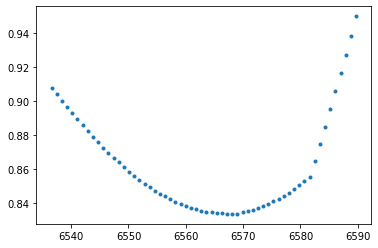

In [208]:
### ih is central index, v mean continuum below, r means continuum above 
### b,t are lower and upper limits of each band
ih0=mi[0]

aindex=np.arange(-30,30,1)

nsa=0.0*aindex
wls=0.0*aindex

for i in aindex:
    ih=ih0+i

    ihb=ih-30
    iht=ih+30
    ihvb=ih-150
    ihvt=ih-90
    ihrb=ih+90
    ihrt=ih+150


    s=np.mean(siM[ihb:iht])
    sv=np.mean(siM[ihvb:ihvt])
    sr=np.mean(siM[ihrb:ihrt])

    nsa[i]=2*s/(sv+sr)
    wls[i]=wlMILES[ih]
    
    
plt.plot(wls,nsa,'.')

print(min(nsa))
print(max(nsa))



(array([24., 11.,  5.,  5.,  4.,  4.,  3.,  1.,  1.,  2.]),
 array([0.83372758, 0.84536332, 0.85699906, 0.8686348 , 0.88027053,
        0.89190627, 0.90354201, 0.91517775, 0.92681348, 0.93844922,
        0.95008496]),
 <a list of 10 Patch objects>)

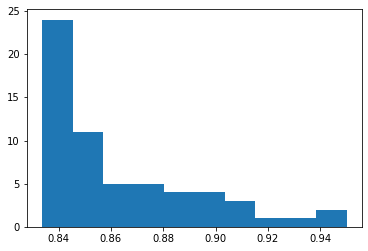

In [209]:
plt.hist(nsa)

# H-beta

0.8047651987109778


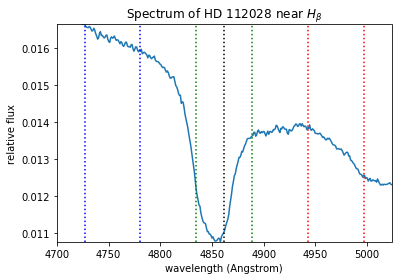

In [210]:
ih=mi[1]

ihb=ih-30
iht=ih+30
ihvb=ih-150
ihvt=ih-90
ihrb=ih+90
ihrt=ih+150

s=np.mean(siM[ihb:iht])
sv=np.mean(siM[ihvb:ihvt])
sr=np.mean(siM[ihrb:ihrt])

normsigh=2*s/(sv+sr)
print(normsigh)

ybottom=min(siM[ihvb:ihrt])
ytop=max(siM[ihvb:ihrt])

plt.plot(wlMILES,siM)
plt.xlabel('wavelength (Angstrom)');
plt.ylabel('relative flux');
plt.title("Spectrum of "+starname+r" near $H_\beta$")

plt.plot((wlMILES[ih], wlMILES[ih]), (ybottom,ytop), ":k")

plt.plot((wlMILES[ihvt],wlMILES[ihvt]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihvb],wlMILES[ihvb]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihrt],wlMILES[ihrt]), (ybottom,ytop), ":r")
plt.plot((wlMILES[ihrb],wlMILES[ihrb]), (ybottom,ytop), ":r")
plt.plot((wlMILES[iht],wlMILES[iht]), (ybottom,ytop), ":g")
plt.plot((wlMILES[ihb],wlMILES[ihb]), (ybottom,ytop), ":g")
#plt.text(halpha, -0.0015, r"$H_\alpha$", color="red", horizontalalignment="center");

plt.xlim((wlMILES[ihvb-30],wlMILES[ihrt+30]))
plt.ylim((min(siM[ihvb:ihrt]),max(siM[ihvb:ihrt])))

normsighb=normsigh

0.7936167861979935
0.9177425812540903


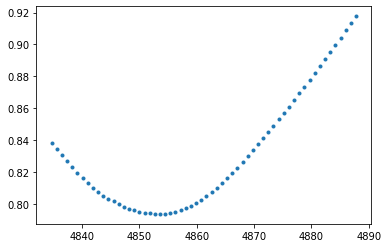

In [211]:
### ih is central index, v mean continuum below, r means continuum above 
### b,t are lower and upper limits of each band
ih0=mi[1]

aindex=np.arange(-30,30,1)

nsa=0.0*aindex
wls=0.0*aindex

for i in aindex:
    ih=ih0+i

    ihb=ih-30
    iht=ih+30
    ihvb=ih-150
    ihvt=ih-90
    ihrb=ih+90
    ihrt=ih+150


    s=np.mean(siM[ihb:iht])
    sv=np.mean(siM[ihvb:ihvt])
    sr=np.mean(siM[ihrb:ihrt])

    nsa[i]=2*s/(sv+sr)
    wls[i]=wlMILES[ih]
    
    
plt.plot(wls,nsa,'.')

print(min(nsa))
print(max(nsa))



(array([21.,  8.,  8.,  5.,  3.,  3.,  3.,  3.,  3.,  3.]),
 array([0.79361679, 0.80602937, 0.81844195, 0.83085452, 0.8432671 ,
        0.85567968, 0.86809226, 0.88050484, 0.89291742, 0.90533   ,
        0.91774258]),
 <a list of 10 Patch objects>)

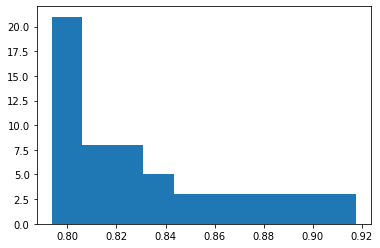

In [212]:
plt.hist(nsa)

# H-gamma

0.8122174784699588


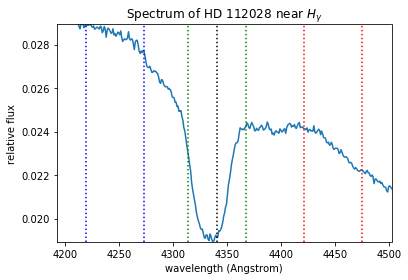

In [213]:
ih=mi[2]


ihb=ih-30
iht=ih+30
ihvb=ih-135
ihvt=ih-75
ihrb=ih+90
ihrt=ih+150

s=np.mean(siM[ihb:iht])
sv=np.mean(siM[ihvb:ihvt])
sr=np.mean(siM[ihrb:ihrt])

normsigh=2*s/(sv+sr)
print(normsigh)

ybottom=min(siM[ihvb:ihrt])
ytop=max(siM[ihvb:ihrt])

plt.plot(wlMILES,siM)
plt.xlabel('wavelength (Angstrom)');
plt.ylabel('relative flux');
plt.title("Spectrum of "+starname+r" near $H_\gamma$")

plt.plot((wlMILES[ih], wlMILES[ih]), (ybottom,ytop), ":k")

plt.plot((wlMILES[ihvt],wlMILES[ihvt]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihvb],wlMILES[ihvb]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihrt],wlMILES[ihrt]), (ybottom,ytop), ":r")
plt.plot((wlMILES[ihrb],wlMILES[ihrb]), (ybottom,ytop), ":r")
plt.plot((wlMILES[iht],wlMILES[iht]), (ybottom,ytop), ":g")
plt.plot((wlMILES[ihb],wlMILES[ihb]), (ybottom,ytop), ":g")
#plt.text(halpha, -0.0015, r"$H_\alpha$", color="red", horizontalalignment="center");

plt.xlim((wlMILES[ihvb-30],wlMILES[ihrt+30]))
plt.ylim((min(siM[ihvb:ihrt]),max(siM[ihvb:ihrt])))

normsighc=normsigh



0.8030989446423301
0.9137196196614569


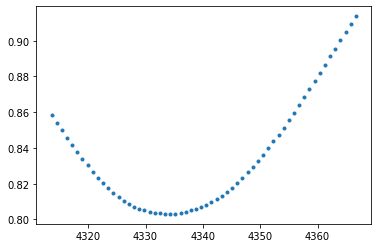

In [214]:
### ih is central index, v mean continuum below, r means continuum above 
### b,t are lower and upper limits of each band
ih0=mi[2]

aindex=np.arange(-30,30,1)

nsa=0.0*aindex
wls=0.0*aindex

for i in aindex:
    ih=ih0+i

    ihb=ih-30
    iht=ih+30
    ihvb=ih-150
    ihvt=ih-90
    ihrb=ih+90
    ihrt=ih+150


    s=np.mean(siM[ihb:iht])
    sv=np.mean(siM[ihvb:ihvt])
    sr=np.mean(siM[ihrb:ihrt])

    nsa[i]=2*s/(sv+sr)
    wls[i]=wlMILES[ih]
    
    
plt.plot(wls,nsa,'.')

print(min(nsa))
print(max(nsa))



# H-delta

0.8678603402597637


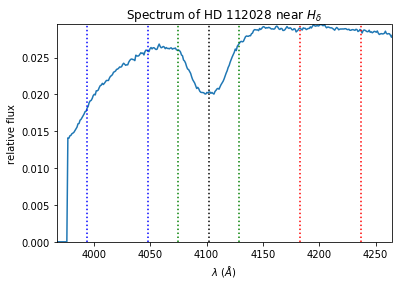

In [256]:
ih=mi[3]

#zero for consistency with alpha, beta, gamma, positive to avoiding sampling missing data
ihv_offset=30 

ihb=ih-30
iht=ih+30
ihvb=ih-150+ihv_offset
ihvt=ih-90+ihv_offset
ihrb=ih+90
ihrt=ih+150

s=np.mean(siM[ihb:iht])
sv=np.mean(siM[ihvb:ihvt])
sr=np.mean(siM[ihrb:ihrt])

normsigh=2*s/(sv+sr)
print(normsigh)

ybottom=min(siM[ihvb-30:ihrt+30])
ytop=max(siM[ihvb-30:ihrt+30])

plt.plot(wlMILES,siM)
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('relative flux');
plt.title("Spectrum of "+starname+r" near $H_\delta$")

plt.plot((wlMILES[ih], wlMILES[ih]), (ybottom,ytop), ":k")

plt.plot((wlMILES[ihvt],wlMILES[ihvt]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihvb],wlMILES[ihvb]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihrt],wlMILES[ihrt]), (ybottom,ytop), ":r")
plt.plot((wlMILES[ihrb],wlMILES[ihrb]), (ybottom,ytop), ":r")
plt.plot((wlMILES[iht],wlMILES[iht]), (ybottom,ytop), ":g")
plt.plot((wlMILES[ihb],wlMILES[ihb]), (ybottom,ytop), ":g")
#plt.text(halpha, -0.0015, r"$H_\alpha$", color="red", horizontalalignment="center");

plt.xlim((wlMILES[ihvb-30],wlMILES[ihrt+30]))
plt.ylim((ybottom,ytop))


plt.savefig(outfilename+"_Hd.svg")
normsighd=normsigh


0.8841586741701395
1.1931413135867472


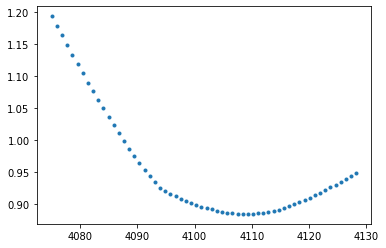

In [257]:
### ih is central index, v mean continuum below, r means continuum above 
### b,t are lower and upper limits of each band
ih0=mi[3]

#zero for consistency with alpha, beta, gamma, positive to avoiding sampling missing data
ihv_offset=20 

aindex=np.arange(-30,30,1)

nsa=0.0*aindex
wls=0.0*aindex

for i in aindex:
    ih=ih0+i

    ihb=ih-30
    iht=ih+30
    ihvb=ih-150+ihv_offset
    ihvt=ih-90+ihv_offset
    ihrb=ih+90
    ihrt=ih+150


    s=np.mean(siM[ihb:iht])
    sv=np.mean(siM[ihvb:ihvt])
    sr=np.mean(siM[ihrb:ihrt])

    nsa[i]=2*s/(sv+sr)
    wls[i]=wlMILES[ih]
    
    
plt.plot(wls,nsa,'.')

print(min(nsa))
print(max(nsa))

ih=ih0

ihb=ih-30
iht=ih+30
ihvb=ih-150+ihv_offset
ihvt=ih-90+ihv_offset
ihrb=ih+90
ihrt=ih+150


In [258]:
print(normsigha,normsighb,normsighc,normsighd)

0.8349625264775237 0.8047651987109778 0.8122174784699588 0.8678603402597637


uncertainty =  0.031002416841784546


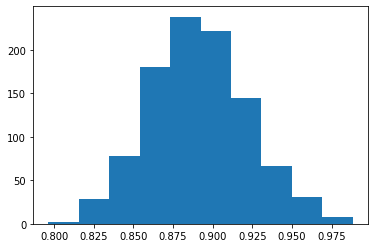

In [259]:
ntrials=1000
nsample=10

ia=np.arange(ntrials)
normsigh=0.0*ia

for i in ia:
    

    siMs=np.random.choice(siM[ihb:iht],nsample)
    s=np.mean(siMs)
    siMs=np.random.choice(siM[ihvb:ihvt],nsample)
    sv=np.mean(siMs)
    siMs=np.random.choice(siM[ihrb:ihrt],nsample)
    sr=np.mean(siMs)
    normsigh[i]=2*s/(sv+sr)
    
plt.hist(normsigh)
print("uncertainty = ",np.std(normsigh))

In [253]:
np.std(normsigh)

0.03124984964709005